In [1]:
import numpy as np
from tensorflow import keras
from sklearn import preprocessing

# Load labels 

train_labels=np.load("train_labels.npy")
val_labels=np.load("val_labels.npy")
test_labels=np.load("test_labels.npy")

num_classes = len(np.unique(train_labels))
print('Total classes: ',num_classes)

# Encodes labels to categorical

le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_num = le.transform(train_labels)
val_labels_num = le.transform(val_labels)
test_labels_num = le.transform(test_labels)

train_labels_bin = keras.utils.to_categorical(train_labels_num, num_classes)
val_labels_bin = keras.utils.to_categorical(val_labels_num, num_classes)
test_labels_bin = keras.utils.to_categorical(test_labels_num, num_classes)



Total classes:  29


In [2]:
from utils.ExpConfiguration import *
from utils.modelUtils import *
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


padd = 'new' # CHANGE HERE to select other padding schemas (new, constant, random)

en = seqEncoders[1] # CHANGE HERE to select different encoders


batch_size = 32
epochs = 10

nl = 3
bn = 0

print('n. layers=',nl,' Encoder=',en['filename'],' Noise=',str(bn), ' Padding=',padd)
train_seq=np.load('train_' + en['filename'] + '_' + padd + '_' + str(bn) + '_seq.npy')
val_seq=np.load('val_' + en['filename'] + '_' + padd + '_' + str(bn) + '_seq.npy')
test_seq=np.load('test_' + en['filename'] + '_' + padd + '_' + str(bn) + '_seq.npy')

train_seq = keras.utils.to_categorical(train_seq)
val_seq = keras.utils.to_categorical(val_seq)
test_seq = keras.utils.to_categorical(test_seq)

if (en['filename'] in ['1mer','2mer','3mer']):
    m=buildCNNModel(inshape=train_seq.shape[1:],num_classes=num_classes,nlayers=nl,cnndim=1)
else:
    m=buildCNNModel(inshape=train_seq.shape[1:],num_classes=num_classes,nlayers=nl,cnndim=2)

print(m.summary())

m.compile(optimizer=keras.optimizers.Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

m.fit(train_seq, train_labels_bin,verbose=1,
                  batch_size=batch_size,shuffle=True,
                  epochs=epochs,#validation_split=0.33,
                  validation_data=(val_seq, val_labels_bin))

#pred = m.predict(test_seq, verbose=1)
#predicted = np.argmax(pred, axis=1)


n. layers= 3  Encoder= 2mer  Noise= 0  Padding= new
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 75, 32)            1664      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 37, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 64)            0         
___________________________________

In [4]:
import tensorflow.keras.backend as K

#If you set the learning_phase to 0 you turn the dropout at test time off and if you set it to 1, it on 
model_mc = K.function([m.input, K.learning_phase()], [m.output])

In [5]:
from utils.ExpConfiguration import *
from utils.modelUtils import *

testfile = 'test_rndseq_t1.fasta'
test_labels_rnd = get_labels(testfile)

seqTestRnd = get_seqs_with_bnoise(testfile,nperc=0)
test_seq_rnd = encode_seqs(seqTestRnd,enc=en['enc'],encparam=en['param'+str(bn)],padding=padd)

test_seq_rnd = keras.utils.to_categorical(test_seq_rnd)



 Done 14530 total records


In [22]:


mc = 50
maxp_rnd = np.empty((len(test_seq_rnd),mc))
maxp_nornd = np.empty((len(test_seq),mc)) #np.zeros((len(test_seq_rnd)))
maxp_train = np.zeros((len(train_seq)))
argmaxp_rnd = np.empty((len(test_seq_rnd),mc))
argmaxp_nornd = np.empty((len(test_seq),mc)) #np.zeros((len(test_seq_rnd)))



for i in range(mc):
    preds_nornd=model_mc([test_seq,1])
    maxp_nornd[:,i]=np.amax(preds_nornd[0],1)
    argmaxp_nornd[:,i]=np.argmax(preds_nornd[0],1)

    
    preds_train=model_mc([train_seq,1])
    maxp_train = maxp_train + np.amax(preds_train[0],1)

    preds_rnd=model_mc([test_seq_rnd,1])
    maxp_rnd[:,i]=np.amax(preds_rnd[0],1)
    argmaxp_rnd[:,i]=np.argmax(preds_rnd[0],1)



#maxp_rnd = maxp_rnd/mc
#maxp_nornd = maxp_nornd/mc
maxp_train = maxp_train/mc

In [19]:
vars_nornd = np.var(maxp_nornd,1)
vars_rnd = np.var(maxp_rnd,1)
means_nornd = np.mean(maxp_nornd,1)
means_rnd = np.mean(maxp_rnd,1)
unique_nornd = np.unique(maxp_nornd,return_counts=True,axis=1)
unique_rnd = np.unique(maxp_rnd,return_counts=True,axis=1)

In [21]:
unique_nornd

(array([[0.99999833, 0.99999857, 0.99999893, ..., 1.        , 1.        ,
         1.        ],
        [0.92782491, 0.81555539, 0.59250492, ..., 0.99848014, 0.99898452,
         0.99931002],
        [0.99998999, 1.        , 0.99856144, ..., 0.9999609 , 0.99601883,
         0.99999619],
        ...,
        [0.85637319, 0.85565615, 0.59509683, ..., 0.65677875, 0.49096975,
         0.99794406],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 0.99998844, 1.        , ..., 0.99995327, 0.99975353,
         0.9999305 ]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]))

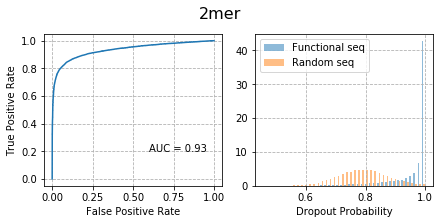

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


pred_prob = np.concatenate([means_nornd, means_rnd])
true_class = np.concatenate([np.ones(len(means_nornd)), np.zeros(len(means_rnd))])

ns_auc = roc_auc_score(true_class, pred_prob)
ns_fpr, ns_tpr, _ = roc_curve(true_class, pred_prob)


fig, axs = pyplot.subplots(1, 2, constrained_layout=True,figsize=(6,3))
fig.suptitle(en['filename'], fontsize=16)

#pyplot.figure(figsize=(6,3))
axs[0].plot(ns_fpr, ns_tpr, linestyle='-')
axs[0].text(0.6, 0.2, 'AUC = %.2f' % ns_auc)
axs[0].grid(linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')

axs[1].hist([means_nornd, means_rnd], bins='auto', density=True, alpha=0.5, label=['Functional seq', 'Random seq'])

axs[1].legend(loc='upper left')
axs[1].grid(linestyle='--')
axs[1].set_xlabel('Dropout Probability')

#
pyplot.savefig('figs/plot_rejection_'+en['filename']+'.pdf')
pyplot.show()

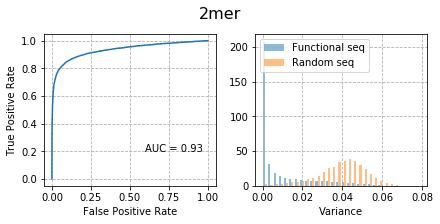

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


pred_vars = np.concatenate([vars_nornd, vars_rnd])
true_class = np.concatenate([np.ones(len(vars_nornd)), np.zeros(len(vars_rnd))])

ns_auc = roc_auc_score(true_class, pred_prob)
ns_fpr, ns_tpr, _ = roc_curve(true_class, pred_prob)


fig, axs = pyplot.subplots(1, 2, constrained_layout=True,figsize=(6,3))
fig.suptitle(en['filename'], fontsize=16)

#pyplot.figure(figsize=(6,3))
axs[0].plot(ns_fpr, ns_tpr, linestyle='-')
axs[0].text(0.6, 0.2, 'AUC = %.2f' % ns_auc)
axs[0].grid(linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')

axs[1].hist([vars_nornd, vars_rnd], bins='auto', density=True, alpha=0.5, label=['Functional seq', 'Random seq'])

axs[1].legend(loc='upper left')
axs[1].grid(linestyle='--')
axs[1].set_xlabel('Variance')

#
pyplot.savefig('figs/plot_rejection_vars_'+en['filename']+'.pdf')
pyplot.show()

In [17]:
np.mean(vars_nornd)

0.009041815936833906